[<sup>Back to Table of Contents</sup>](0_intro_and_TOC.ipynb/#toc) <a id="apps"></a>

In [1]:
import oyster as oy

# Applications of Causal Diagrams 
Having explained what Causal Diagrams are, the next natural question is: "what are they good for?"

## Independence and D-separation <a id="d_sep"></a>

When creating a Causal Diagram, you specified the direct relationships among the variables in the edge list.  But you also got something for free: the model you specified also automatically contains information about which variables are *not* related to one another.  It may seem trivial, but this concept of ***independence*** among variables—the idea that "wiggling" the value of one variable does not cause the other to "wiggle"—is actually quite powerful and something we will use again and again in causal inference.

Obviously, if you cannot trace a path between two variables in a Causal Diagram, then they are independent from one another in the causal model the diagram represents.[<sup>1</sup>](#footnote1) <a id="back1"></a>  But variables can also be rendered independent of one another by ***blocking*** all paths between them.  Blocking works by choosing to either condition or *not* condition on the variables on a path according to the following rules:

Think of a given path as containing one or more of the following structures: forks (A <- B -> C), chains (A -> B -> C), and colliders (A -> B <- C).  Except for the nodes at each end, every node in a path is either the middle node of a fork, chain, or collider in the context of that path (more than 2 arrows and you're looking at more than one path).  For example, if one path between X and Y in a Causal Diagram can be traced as X -> D -> E <- Y, that path contains a chain through D and a collider at E.  The same diagram might have another path X <- F -> E -> G -> Y; in this path F is a fork, and E and G are both chains (even though E was a collider on the first path).

A path is blocked by conditioning on one or more nodes that are chains or forks, **not** conditioning on one or more colliders, or some combination of these. So in the case of the path X -> D -> E <- Y, one way the path can be blocked is by conditioning on D.  But another way to block the path is to do nothing at all; as a collider, E blocks the path by default.  If you only condition E, the path is *not* blocked; as conditioning on a collider *re-opens* the path.  Finally, if you condition on both D and E, the path is blocked again; its ok to condition on a collider so long as the path is blocked elsewhere.

As we saw in the last section, two variables might have many paths between them in a Causal Diagram.  Two variables are said to be ***d-separated*** by a set of nodes if that set of nodes blocks every path between the two variables.

Oyster has a suite of functions that deal with d-separation and independencies in Causal Diagrams.  Let's look at some exampes from Pearl's Primer.

Consider the following graph, which is just one long path). Since I will simply print it using `print_path`. I could also have drawn it using `draw`.

In [2]:
fig2_5 = oy.CausalDiagram([('X', 'R'), ('R', 'S'), ('S', 'T'), 
                           ('U', 'T'), ('V', 'U'), ('V', 'Y')])
print('Figure 2.5\n')
oy.print_path(fig2_5, start='X')

Figure 2.5

X -> R -> S -> T <- U <- V -> Y


> #### Study Question 2.3.1 <a id="sq231"></a>
> a) List all pairs of variables in Figure 2.5 that are independent, conditional on the set Z = {R, V} 

Two variables are independent if the path between them is blocked by the conditioned variables.  If not, the variables are possibly (actually very likely, with a few specific  exceptions) dependent. 

Oyster's `d_separated` function checks for d-separation between two sets of variables, given a conditioning set:

In [3]:
Z = {'R', 'V'}
print('Given {R,V}...')
for a,b in oy.combinations(fig2_5.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_5, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')
    else: print(f'{a} and {b} are possibly dependent.')

Given {R,V}...
X and Y are independent.
X and T are independent.
X and S are independent.
X and U are independent.
Y and T are independent.
Y and S are independent.
Y and U are independent.
T and S are possibly dependent.
T and U are possibly dependent.
S and U are independent.


> b) For each pair of non-adjacent variables in Figure 2.5, give a set of variables that, when conditioned on, renders that pair independent.

Oyster's `d_separator_search` function conducts an exhaustive search for d_seperators over all possible combinations of the other nodes in a graph.  For simplicity, we select just one below.  Oyster also provides a utility function `NA_pairs` for selecting the nonadjacent pairs in a graph.

In [4]:
for a,b in oy.NA_pairs(fig2_5):
    separators = oy.d_separator_search(fig2_5, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

X,S: {'R'}
X,T: {'R'}
U,X: set()
V,X: set()
X,Y: set()
R,T: {'S'}
R,U: set()
R,V: set()
R,Y: set()
U,S: set()
V,S: set()
S,Y: set()
V,T: {'U'}
Y,T: {'V'}
U,Y: {'V'}


`set()` means that no variables need be conditioned on to render the pair independent.  In other words, they are ***marginally independent***.


See [further discussion](#impliedIndependencies) of this concept of `implied independencies` and a better, dedicated Oyster tool for finding them in study question 2.4.1 below.

> c) List all pairs of variables in the graph of Figure 2.6 that are independent conditional on the set Z={R,P}.

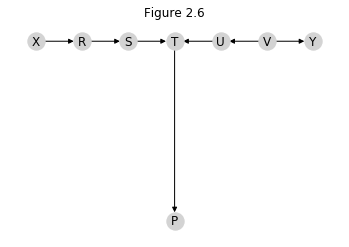

In [5]:
#Pulling the graph from `oyster.examples`...
fig2_6 = oy.ex.primer['fig2_6']
oy.draw(fig2_6, title='Figure 2.6')

as in part a)...

In [6]:
Z = {'R', 'P'}
print('Given {R,P}...')
for a,b in oy.combinations(fig2_6.nodes - Z, 2): # for all pairs of nodes not in Z...
    ind = oy.d_separated(fig2_6, a, b, Z)
    if ind: print(f'{a} and {b} are independent.')

Given {R,P}...
X and V are independent.
X and T are independent.
X and Y are independent.
X and S are independent.
X and U are independent.


> d) For each pair of non-adjacent variables in Figure 2.6, give a set of variables that, when conditioned on, renders that pair independent.

as in part b) (and recalling that I show [a better way below](#impliedIndependencies) using `implied_indepenencies`).

In [7]:
for a,b in oy.NA_pairs(fig2_6):
    separators = oy.d_separator_search(fig2_6, a, b)[0] # just one set.
    print(f'{a},{b}: {separators}')

X,S: {'R'}
X,T: {'R'}
P,X: {'T'}
U,X: set()
V,X: set()
X,Y: set()
R,T: {'S'}
R,P: {'T'}
R,U: set()
R,V: set()
R,Y: set()
P,S: {'T'}
U,S: set()
V,S: set()
S,Y: set()
V,T: {'U'}
Y,T: {'V'}
P,U: {'T'}
P,V: {'T'}
P,Y: {'T'}
U,Y: {'V'}


> e) Suppose we generate data by the model described in Figure 2.5, and we fit them with the linear equation Y = a + bX + cZ. Which of the variables in the model may be chosen for Z so as to guarantee that the slope b would be equal to zero?

If two variables are independent, then their coefficient in a linear regression equation is 0.  So in other words, which (single) variables Z d-separate X and Y?

In [8]:
[z for z in oy.d_separator_search(fig2_5, 'X', 'Y') if len(z) == 1]

[{'R'}, {'S'}, {'V'}, {'U'}]

> f) Continuing question (e), suppose we fit the data with the equation: 
>
\begin{equation*}
 Y = a + bX + cR + dS + eT + fP
\end{equation*}

> which of the coefficients would be zero?

Here, the question can be reworded as "which of {X, R, S, T, P} is independent of Y, given the rest of those variables?"

In [9]:
variables = {'X', 'R', 'S', 'T', 'P'}

[v for v in variables if oy.d_separated(fig2_6, v, 'Y', variables - {v})]

['X', 'P', 'R']

---
## Implied Independencies and Testable Implications <a id="impliedIndependencies"></a>

You might still be wondering why we go through the trouble of identifying which variables are independent of one another in a causal diagram.  One particularly good reason is because for each independence relation we find, we have a statistical test to check the validity of our causal model. A model's ***implied independancies*** represent ***testable implications***. 

Given a dataset and a causal diagram proporting to explain it, one can examine the if two variables remain correlated after controlling for factors that d-separate the variables in the causal diagram. If so, then the model is flawed; the model implied an independence that the data did not show.

D-separation thus provides an objective way to approach analytical arguments: say you and a colleague have two competing hypotheses about the way the world works.  You both draw causal diagrams representing your view; if the models have different implied independencies, then you can see which of those sets of independencies is borne out in the data.  If one of the models (or both) implies an independence where there clearly isn't one, then you can be sure that that model is wrong.

> #### Study Question 2.4.1 <a id="sq241"></a>
> Considering Figure 2.9...

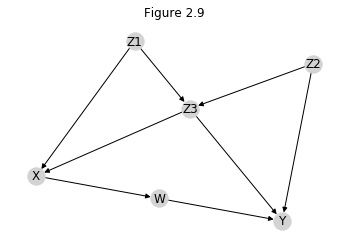

In [10]:
fig2_9 = oy.ex.primer['fig2_9']
oy.draw(fig2_9, title='Figure 2.9')

> a) For each pair of non-adjacent nodes in this graph, find a set of variables that d-separates that pair. What does this list tell us about independencies in the data?

Oyster provides a top-level function, `implied_independencies`, for finding displaying the independencies implied by a model.

In [11]:
oy.implied_independencies(fig2_9)

Implied independencies:
X ⫫ Y | [{'W', 'Z1', 'Z3'}, {'W', 'Z3', 'Z2'}]
X ⫫ Z2 | [{'Z1', 'Z3'}]
W ⫫ Z1 | [{'X'}]
W ⫫ Z3 | [{'X'}]
W ⫫ Z2 | [{'X'}, {'Z1', 'Z3'}]
Z1 ⫫ Y | [{'W', 'Z3', 'Z2'}, {'X', 'Z3', 'Z2'}]
Z1 ⫫ Z2 | [set()]


<a id="minsets"></a>
Read the "⫫" symbol as "is independant of," and the "|" symbol as "given" or "conditional on." So, X and Y are independent given Z1, W, and Z3.  X and Y are also independent given Z2, W, and Z3.  Z1 and Z2 are marginally independent; they are independant without needing to control for any variables.  There are more seperating sets for Figure 2.9 than those listed above, but every other set is a superset of these sets; these are ***minimal separating sets,*** every other valid separating set would include at least one extraneous variable.  Minimal separating sets are an important concept because they allow independencies to be analyzed with as few covariate adjustments (in other words, controlling for as few variables) as possible, which among other good things means the sample sizes for each matching covariate category are larger.  Oyster provides a utility function `minimal_sets` that determines the minimal sets from a provided list of sets.

Another way to examine d-separating sets would be to run a `d_separator_search` for each nonadjacent pair. This is what `implied_independancies` does behind the scenes, returning only the `minimal_sets`.

In [12]:
all_X_Y_d_separators = oy.d_separator_search(fig2_9, 'X', 'Y')
print('d-separating sets for X ⫫ Y in Figure 2.9:')
print(f'All: {all_X_Y_d_separators}')
print(f'Minimal: {oy.minimal_sets(all_X_Y_d_separators)}')

d-separating sets for X ⫫ Y in Figure 2.9:
All: [{'W', 'Z1', 'Z3'}, {'W', 'Z3', 'Z2'}, {'W', 'Z1', 'Z3', 'Z2'}]
Minimal: [{'W', 'Z1', 'Z3'}, {'W', 'Z3', 'Z2'}]


> b) Repeat question (a) assuming that only variables in the set {Z3,W,X,Z1} can be measured.

<a id="unmeasured"></a>
Causal Diagrams will often include factors or variables for which we do not have data.  This might be because it is too expensive or otherwise impractical to collect the data, or because the factor itself is ***unmeasurable*** (such as a hypothesized but unidentified genetic component).  

Now, instead of taking the minimal sets as is done with `implied_independencies`, we will run an exhaustive `d_separator_search` against nonadjacent pairs, and filter the results such that the seperating sets include only measurable variables, and only for measurable pairs.

In [13]:
measurable = {'Z3','W','X','Z1'}

all_d_seps_for_measurable_pairs = [(a,b, oy.d_separator_search(fig2_9, a, b))
                                   for a,b in oy.NA_pairs(fig2_9) 
                                   if a in measurable and b in measurable]

for (a,b,sep) in all_d_seps_for_measurable_pairs:
    print(f'{a} ⫫ {b} | {list(filter(lambda s: s < measurable, sep))}')

W ⫫ Z1 | [{'X'}, {'X', 'Z3'}]
W ⫫ Z3 | [{'X'}, {'X', 'Z1'}]


> c) For each pair of non-adjacent nodes in the graph, determine whether they are independent conditional on all other variables.

In [14]:
for (a,b) in oy.NA_pairs(fig2_9):
    all_other_variables = fig2_9.nodes - {a} - {b}
    ind = oy.d_separated(fig2_9, a, b, all_other_variables)
    if ind: print(f'{a} ⫫ {b} | {all_other_variables}')

X ⫫ Y | {'W', 'Z3', 'Z1', 'Z2'}
X ⫫ Z2 | {'W', 'Z1', 'Z3', 'Y'}
W ⫫ Z1 | {'X', 'Z3', 'Z2', 'Y'}
Z1 ⫫ Y | {'W', 'X', 'Z3', 'Z2'}


---
## Causal Diagram Analysis for Prediction and Variable Selection <a id="predictionAndVariableSelection"></a>

Closely related to the question of how variables are related to one another is the question of prediction: can we predict what the value of a variable will be in a given situation?  Here the "situation" is the state of other variables, or predictors.  This is often done by using a dataset which records observations of the value of the variable to be predicted along with the values of the predictor variables, and finding the equation for a line that best fits that data; each predictor variable appears in that equation along with a coefficient that establishes how much the predicted variable changes given a one-unit change in the predictor.<sup>[2](#footnote2)</sup> <a id="back2"></a>

Causal Diagrams can help by optimizing which variables to use in making predictions. An important result from Pearl's earlier research in the related field of Bayesian Networks (which also use directed acyclic graphs) is that a variable in a DAG is independent of all other variables in the graph given the set of its parents, its children, and all its children's other parents.  This set is known as a variable's ***Markov Blanket***. Moreover, the Markov Blanket is guaranteed to be minimal—if you have all the variables in this set, then adding any other variable is unnecessary when it comes to making predictions for that variable.

> #### Study Question 2.4.1, cont'd <a id="sq241contd"></a>
> d) For every variable V in Figure 2.9, find a minimal set of nodes that renders V independent of all other variables in the graph.

<a id="mb"></a>
This set corresponds to the variable's Markov Blanket, and is accessible via the `MB` utility function.

In [15]:
for node in fig2_9.nodes:
    mb = oy.MB(fig2_9, node)
    print(f'{node} ⫫ {fig2_9.nodes - mb} | {mb}')

X ⫫ {'X', 'Z2', 'Y'} | {'W', 'Z1', 'Z3'}
W ⫫ {'W', 'Z1'} | {'X', 'Z3', 'Z2', 'Y'}
Y ⫫ {'X', 'Z1', 'Y'} | {'W', 'Z3', 'Z2'}
Z1 ⫫ {'W', 'Z1', 'Y'} | {'X', 'Z3', 'Z2'}
Z3 ⫫ {'Z3'} | {'X', 'Z1', 'W', 'Z2', 'Y'}
Z2 ⫫ {'X', 'Z2'} | {'W', 'Z1', 'Z3', 'Y'}


> e) Suppose we wish to estimate the value of Y from measurements taken on all other variables in the model. Find the smallest set of variables that would yield as good an estimate as before.

This is an important application of the Markov Blanket. Because it renders the variable independent from every other factor, a variable's Markov Blanket is the minimal set of variables that contain all the knowledge needed to predict it.

In [16]:
oy.MB(fig2_9, 'Y')

{'W', 'Z2', 'Z3'}

If you were a glutton for punishment you could also find the minimal sets of the intersection of the sets of sets that d-separate Y from every nonadjacent node (that's a mouthful!):

In [17]:
separating_sets_for_NA_nodes = [oy.d_separator_search(fig2_9, 'Y', node)
                                for node in oy.NA(fig2_9, 'Y')]

intersection = {frozenset(s) for s in separating_sets_for_NA_nodes[0]}
for node in separating_sets_for_NA_nodes[1:]:
    intersection.intersection_update({frozenset(s) for s in node})

[set(s) for s in intersection]

[{'W', 'Z2', 'Z3'}]

> f) Repeat Question (e) assuming that we wish to estimate the value of Z2

In [18]:
oy.MB(fig2_9, 'Z2')

{'W', 'Y', 'Z1', 'Z3'}

> g) Suppose we wish to predict the value of Z2 from measurements of Z3. Would the quality of our prediction improve if we add measurement of W? Explain.

In other words...is W d-separated from Z2, given Z3?

In [19]:
oy.d_separated(fig2_9, 'Z2', 'W', 'Z3')

False

W is not d-separated from Z2, given Z3.  So, does including it as a measurement improve our predction of Z2?  The answer is: "Probably, but...".  

Since W remains correlated with Z2 when conditioning on Z3, including it will provide additional information that can improve predictions of Z2. But whether the improvement will be worth the cost of making the model more complicated is not a straightforward question, because in addition to possibly increasing the costs of collecting data, it also might make the model harder to explain, etc.

If W *were* d-separated (i.e. conditionally independent, given Z3), then adding it to the model would not add additional information and the answer would be simply "No."  This test can help guard against a common mistake in statistics of ***overfitting data***, where adding additional variables appears to improve predictions against its in-sample training data (at least according to the commonly-used statistical measure R²), but in reality it makes the model perform worse on out-of-sample data.

To summarize the value of graphical analysis for ***variable selection***: a causal model implies that some variables (those that are d-separated, a.k.a independent of the variable to be predicted, in the causal diagram conditional on the other variables being measured), are certainly not worth including when making predictions.  Variables are shown to be d-connected from inspecting the causal diagram can increase predictive accuracy if included, but researchers should ask "At what cost?"

## Equivalence Classes and CPDAGs for Causal Search and Alternative Hypotheses<a id="cpdag"></a>

Let's start this section with an example from Pearl's Primer.  We can address the following questions simultaneously.

> #### Study Question 2.5.1 <a id="sq251"></a>
> a) Which of the arrows in Figure 2.9 can be reversed without being detected by any statistical test?
>
> b) List all the graphs that are observationally equivalent to the one in Figure 2.9.
>
> c) List the arrows in Figure 2.9 whose directionality can be determined from nonexperimental data.

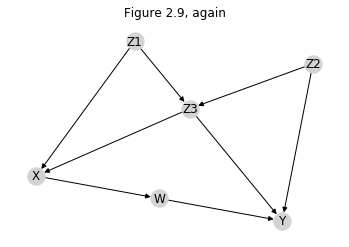

In [20]:
oy.draw(fig2_9, title='Figure 2.9, again') # Still using fig2_9 as above

The "statistical tests" mentioned above check for independencies between variables. So in other words, the question asks: How many graphs can be formed from reversing the direction of any edge in Figure 2.9, while still implying the same set of independencies?  

The set of graphs with the same skeleton (the same nodes, and the same edges between nodes, only the edges can be in either direction) and the same implied independencies is called an ***equivalence class.*** Oyster provides a function for the `equivalence_class_size` of a given causal diagram.

In [21]:
oy.equivalence_class_size(fig2_9)

1

An equivalence class size of 1 means that, in Figure 2.9, *no arrows* can be reversed without the resulting graph having a different set of implied independencies (part a).  So there are no other observationally equivalent graphs (part b), and all arrows can be determined from nonexperimental data (part c).  It's a trick question!  But often things are more complicated than Figure 2.9...

The ***Complete Partial DAG (CPDAG)*** is a related concept to equivalence class.  The CPDAG is a partially-directed graph, where edges that are *compelled* to have a certain direction based on implied independencies are represented as normal, but edges that can be reversed are shown as undirected (or, equivalently, with arrows at both ends).  CPDAGs summarize an equivalence class in a single graph; pick an arbirary direction for each undirected edge and the resulting graph is a member of the same equivalence class.  The size of an equivalence class is thus $2^{n}$, where n is the number of reversible edges in the CPDAG.

CPDAGs and equivalence classes have two important applications:
    
1. In the field of ***causal search***, a dataset is interrogated for any independence relationships between variables, and the resulting independencies can be used to generate a graph that explains the data.  Think of this as going in reverse from how we've considered graphs so far: where so far we have hypothesized a causal diagram that can verified against the data, causal search takes the data and generates a graph that fits.  The catch is that these causal search methods can only go so far, because there might be several graphs that explain the data, with arrows in different directions so long as they don't violate an independence in the data.  Thus causal search methods generate CPDAGs, rarely a specific DAG corresponding to a single causal model.

1. CPDAG's summarize the valid ***alternative hypotheses*** that could correctly explain a dataset, in addition to a given valid causal model.  In many fields it pays to be aware of the fact that different explainations could exist that are just as consistent with the collected data; articulating these alternative competing hypotheses as equivalent causal diagrams is a starting point for devising followon experiments that can focus on deciding between alternative causal models.

Oyster's `dag_to_cpdag` function returns a CPDAG from a given DAG.  As expected, the CPDAG for Figure 2.9 is the same as Figure 2.9; all of the edges are compelled to one direction by Figure 2.9's implied independencies.

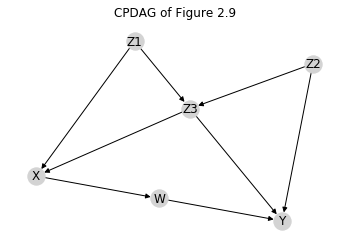

In [22]:
oy.draw(oy.dag_to_cpdag(fig2_9), pos=oy.ex.pos[fig2_9], title='CPDAG of Figure 2.9')

For a more illuminating example, let's look at Figure 1.8. Oyster also provides a visualization function `draw_cpdag` that draws the graph and its CPDAG side-by-side.

equivalent dags: 128


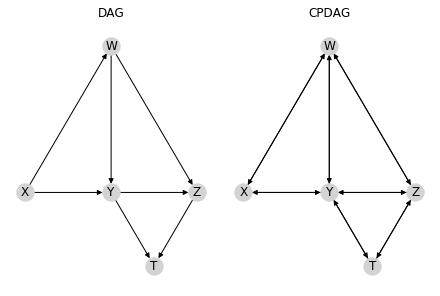

In [23]:
fig1_8 = oy.ex.primer['fig1_8']
oy.draw_cpdag(fig1_8, pos=oy.ex.pos[fig1_8])

Every one of the directed edges in Figure 1_8 can be reversed, while still implying the same independencies!

> d) Write down a regression equation for Y such that, if a certain coefficient in that equation is nonzero, the model of Figure 2.9 is wrong.

We're going back to Figure 2.9 now.  Again, we check the implied independencies:

In [24]:
oy.implied_independencies(fig2_9)

Implied independencies:
X ⫫ Y | [{'W', 'Z1', 'Z3'}, {'W', 'Z3', 'Z2'}]
X ⫫ Z2 | [{'Z1', 'Z3'}]
W ⫫ Z1 | [{'X'}]
W ⫫ Z3 | [{'X'}]
W ⫫ Z2 | [{'X'}, {'Z1', 'Z3'}]
Z1 ⫫ Y | [{'W', 'Z3', 'Z2'}, {'X', 'Z3', 'Z2'}]
Z1 ⫫ Z2 | [set()]


We see that Y should be independent of X given W, Z1, and Z3.  Thus, in a regression equation Y ~ aX + bW + cZ1 + dZ3, if a is nonzero, (implying X and Y are *not* independent, given W, Z1, and Z3), the model would be wrong.

> e) Repeat part (d) for variable Z3.

As above, `oy.implied_independencies` shows us that W and Z3 are independent given X.  So a regression Z3 ~ fW + gX, f should be zero.

> f) Repeat part (e), assuming X is not measured.

If X is immeasurable, we aren't able to use it in a regression equaition.  Since the only independence relationship for Z3 above must include X, we conclude that we can't write a regression equation to test the model without X. Another trick question!

> g) How many regression equations of the type described in (d) and (e) are needed to ensure that the model is fully tested, namely, that if it passes all these tests it cannot be refuted by additional tests of this kind.

This set of equations is called a ***basis set***.  In other words, were looking for a set of equations that show a variable is independent of its non-decendents, given its parents.  This set mirrors the *Rule of Product Decomposition*, which says that for an acyclic graph, 

\begin{equation*}
P(x_{1}, x_{2}, ..., x_{n}) = \prod_{i}P(x_{i}|pa_{i})
\end{equation*}

Oyster provides a function to print these independencies under `basis_set`

In [25]:
oy.basis_set(fig2_9)

X ⫫ {'Z2'} | {'Z1', 'Z3'}
W ⫫ {'Z3', 'Z1', 'Z2'} | {'X'}
Y ⫫ {'X', 'Z1'} | {'W', 'Z3', 'Z2'}
Z1 ⫫ {'Z2'} | set()
Z2 ⫫ {'Z1'} | set()


The independence relations for Z1 and Z2 are the same, so we really only need 4 equations.  

You should now have an appreciation for some of the uses for causal diagrams in analysis.  In summary, by leveraging th concept of d-separation, causal diagrams can show what independencies a causal model implies ought to be present in the data; this fact can be used to refute a causal model, make smart choices about which variables to consider when making predictions, or generate alternative causal models that explain a given dataset.  In the [next section](3_interventions.ipynb), we look at how to use Oyster to unlock causal diagrams' potential for evaluating and comparing potential **interventions** or policy decisions.

---
## *Addendum*: A Graphical Algorithm for D-Separation <a id="d_sep_graph"></a>

Another way to understand d-seperation is by the following ***graphical algorithm***, adapted from [this worksheet](http://web.mit.edu/jmn/www/6.034/d-separation.pdf) from MIT.  The algorithm automatically checks every path according to Pearl's rules above and works for multi-variable sets of X, Y, and/or Z.  For complicated graphs, this technique is often much easier to follow and visualize than trying to determine if each path is blocked, one-by-one.
1. Draw the "ancestral graph" of the variables in question, i.e. the subgraph containing X, Y, Z, and their ancestors.
1. "Moralize" the ancestral graph by adding edges between all parents of a node.
1. Draw a subgraph of the moral graph, omitting nodes in Z.
1. If X and Y are now disconnected, Z d-separates X and Y.

Oyster provides a visualization for this algorithm with `d_sep_graphs`.

X d-separated from Y by {'Z3'}? False


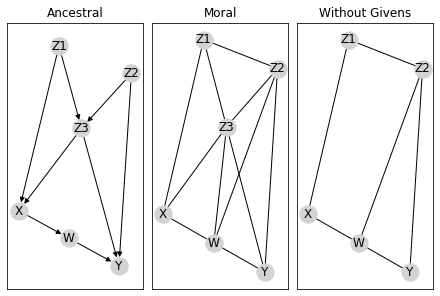

In [26]:
fig = oy.ex.primer['fig2_9']
X,Y,Z = 'X', 'Y', {'Z3'}
print(f'{X} d-separated from {Y} by {Z}? {oy.d_separated(fig, X, Y, Z)}')
oy.d_sep_graphs(fig, X, Y, Z)

#### Footnotes
---
<a id="footnote1"></a> 
[1] Of course, the data might disagree and show that in reality there is a correlation between these two variables; if so, then it is a signal that there is a problem with the causal model, not in the diagram's ability to represent it.[↻](#back1)

<a id="footnote2"></a> 
[2] Readers with a background in statistics will recognize this description as a simplification to linear models, but rest assured that the value of causal diagrams for variable selection applies to nonlinear relationships as well.[↻](#back2)